In [83]:
!pip install contractions


In [84]:
!pip install -U spacy
!python -m spacy download en_core_web_sm


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 58.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [85]:
!pip install xgboost


In [86]:
!pip install emoji --quiet


In [87]:
!pip install deep-translator --quiet


In [88]:
!pip install langdetect --quiet


## Download the sentiment analysis Dataset from kaggle.

In [89]:
import kagglehub

In [90]:

# Download English Data
path = kagglehub.dataset_download("abdelmalekeladjelet/sentiment-analysis-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-dataset


## explore the Data.

In [91]:
import pandas as pd
English_df = pd.read_csv('/kaggle/input/sentiment-analysis-dataset/sentiment_data.csv',index_col=0)
English_df.head()


,Comment,Sentiment
0,lets forget apple pay required brand new iphon...,1
1,nz retailers don’t even contactless credit car...,0
2,forever acknowledge channel help lessons ideas...,2
3,whenever go place doesn’t take apple pay doesn...,0
4,apple pay convenient secure easy use used kore...,2


In [92]:
English_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241145 entries, 0 to 241925
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Comment    240928 non-null  object
 1   Sentiment  241145 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


In [93]:
English_df['Sentiment'].unique()
len(English_df[English_df['Comment'].isna()])

217

In [94]:
241145-217

240928

first, we need to remove null comments and null sentiment

In [95]:
df= English_df.dropna(subset=['Sentiment','Comment'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 240928 entries, 0 to 241925
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Comment    240928 non-null  object
 1   Sentiment  240928 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ MB


fix the non continous index

In [96]:
df.reset_index(drop=True,inplace=True)
df.head()

,Comment,Sentiment
0,lets forget apple pay required brand new iphon...,1
1,nz retailers don’t even contactless credit car...,0
2,forever acknowledge channel help lessons ideas...,2
3,whenever go place doesn’t take apple pay doesn...,0
4,apple pay convenient secure easy use used kore...,2


## Preprocessing pipeline

In [97]:
df.shape

(240928, 2)

### detect non-english comments and translate them (if any).

In [98]:
from langdetect import detect
from langdetect.lang_detect_exception import LangDetectException

# Detect language (safe version to handle short/empty texts)
def detect_language(text):
    try:
        return detect(text)
    except LangDetectException:
        return "unknown"

# Apply to your comments
df['language'] = df['Comment'].apply(detect_language)

# Filter non-English comments
non_english = df[df['language'] != 'en']
print(f"Non-English comments: {len(non_english)}")

# View a few examples
non_english.head()


Non-English comments: 48389


/tmp/ipython-input-98-1858279364.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['language'] = df['Comment'].apply(detect_language)


,Comment,Sentiment,language
24,linus table also linus lets use chair,1,et
27,dan treasure channel long lacked mr fixit type...,2,fr
30,unstoppable experiments liquid nitrogen,2,fr
32,liquid nitrogen ഇതുവരെ തീർന്നില്ലേ മച്ചാനെ,1,ml
33,liquid nitrogen never ends poli,2,fr


In [99]:
non_english['language'].value_counts()

,count
language,
it,9311
af,5385
fr,3913
id,3608
et,2817
cy,2761
nl,2299
so,1979
da,1952


In [100]:
non_english['Sentiment'].value_counts()

,count
Sentiment,
1,25666
2,14857
0,7866


In [101]:
non_english[non_english['language']=='ar']

,Comment,Sentiment,language
1108,الشعب يطالب للتنزيل بشكل يومي جماعا منو يتفق معي,1,ar
1109,مقطع مميز جداً ،ضحكت من أعماق قلبي ، وياريت تك...,1,ar
1110,مقطع مميز جداً ،ضحكت من صماصيم قلبي وياريت تكث...,1,ar
1111,اكثر شخص يستحق الشهره بسبب المحتوى الي يقدمه,1,ar
1112,الله يسعدك مثل ما بتسعدنا فعلا مثل ما قلت ضحك فلل,1,ar
1113,والله مقطع اسطوري,1,ar
1114,والله متت من الضحك الله يسلم هالايدين,2,ar
1115,ياخي المقطع خرافي ورياكشنات ماهر مضحكة بجد,1,ar
1116,الله لا يحرمنا من مقاطعك الحلوة يا فن,1,ar
1117,الله يسعدك ابو محمود قديش متنا ضحك مع العيله,2,ar


my decision after taking a look over the non english data is to delete them

In [102]:
df_en=df[df['language'] == 'en']

check for class imbalancing

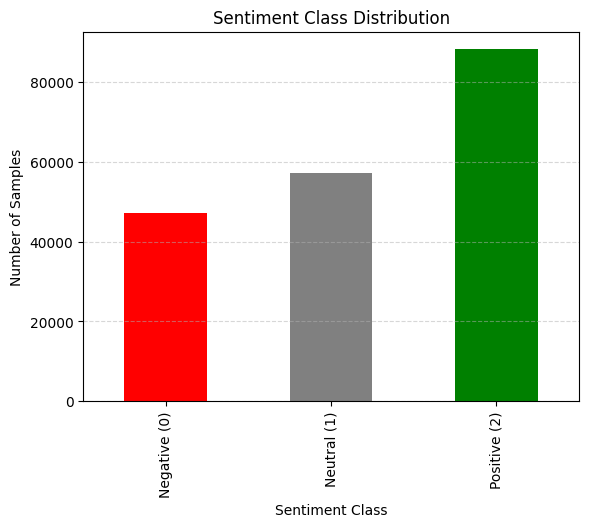

In [103]:
import matplotlib.pyplot as plt

# Replace 'sentiment' with your actual column name (e.g., 'label' or 'target')
df_en['Sentiment'].value_counts().sort_index().plot(kind='bar', color=['red', 'gray', 'green'])

plt.title('Sentiment Class Distribution')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Samples')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (0)', 'Neutral (1)', 'Positive (2)'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


applying down sampling to positive class down to 60000 to handle class imbalance

In [104]:
from sklearn.utils import resample

# Split the dataframe by class
df_0 = df_en[df_en['Sentiment'] == 0]
df_1 = df_en[df_en['Sentiment'] == 1]
df_2 = df_en[df_en['Sentiment'] == 2]

min_count = 60000

# Downsample to min_count

df_2_down = resample(df_2, replace=False, n_samples=min_count, random_state=42)

# Combine balanced DataFrame
df_balanced = pd.concat([df_0, df_1, df_2_down])

# Shuffle the result
df_en = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)


In [105]:
print(df_en['Sentiment'].value_counts())
print(df_en.shape[0])

Sentiment
2    60000
1    57111
0    47239
Name: count, dtype: int64
164350


### lowercasing

In [106]:
df_en['Comment'] = df_en['Comment'].str.lower()

### removing punctuation

In [107]:
df_en['Comment']=df_en['Comment'].str.replace("[^\w\s']",'') #keep the apostrophe (') to apply contraction expansion

apply contraction expansion

In [108]:
import contractions

df_en['Comment'] = df_en['Comment'].apply(lambda x: contractions.fix(x))
df_en.head()

,Comment,Sentiment,language
0,i am sorry songbyrds husband really creeps lol...,0,en
1,modi thinks climate change hoax understand tri...,1,en
2,bjp supporters say job opportunities india got...,0,en
3,cannot wait till tomorrow new day,1,en
4,watching wizard waverly place,1,en


check for emojis and fix them

In [109]:
import re

# Emoji detection regex (covers most emojis)
emoji_pattern = re.compile(
    "["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map
    u"\U0001F1E0-\U0001F1FF"  # flags
    u"\U00002700-\U000027BF"  # miscellaneous symbols
    u"\U0001F900-\U0001F9FF"  # supplemental symbols
    u"\U00002600-\U000026FF"  # weather, arrows, etc.
    "]+", flags=re.UNICODE
)


comments that have emojis in it

In [110]:
contains_emoji = df['Comment'].apply(lambda x: bool(emoji_pattern.search(x)))

# View count
print("Comments with emojis:", contains_emoji.sum())

# Optional: View examples
df[contains_emoji].head()


Comments with emojis: 322


,Comment,Sentiment,language
952,artistic music mix top songs ♫ best ncs gaming...,1,en
1715,looks delicious ♡,2,es
3245,right great insight started investing years ag...,2,en
3354,think literally saved life i’ve struggling fin...,2,en
3873,thanks update always appreciate insight im rea...,2,en


In [111]:
import emoji

# Replace emojis with text equivalents (demojize)
df_en['Comment'] = df_en['Comment'].apply(lambda x: emoji.demojize(x, language='en'))


remove all left punctuations

In [112]:
df_en['Comment']=df_en['Comment'].str.replace("[^\w\s_]",'')

In [113]:
df_en['Comment']=df_en['Comment'].str.replace("_",' ')

remove numbers from text

In [114]:
df_en['Comment']=df_en['Comment'].str.replace('\d+', '')

Apply tokenization

In [115]:
df_en['Comment']=df_en['Comment'].str.split()

df_en.head()

,Comment,Sentiment,language
0,"[i, am, sorry, songbyrds, husband, really, cre...",0,en
1,"[modi, thinks, climate, change, hoax, understa...",1,en
2,"[bjp, supporters, say, job, opportunities, ind...",0,en
3,"[cannot, wait, till, tomorrow, new, day]",1,en
4,"[watching, wizard, waverly, place]",1,en


In [116]:
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164350 entries, 0 to 164349
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Comment    164350 non-null  object
 1   Sentiment  164350 non-null  int64 
 2   language   164350 non-null  object
dtypes: int64(1), object(2)
memory usage: 3.8+ MB


In [117]:
df_en[df_en['Comment'].isna()]

,Comment,Sentiment,language


removing of stop words (except for 'not' as removing it can change the meaning)

In [118]:
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.remove('not')  # execluding not from the stop words list
df_en['Comment'] = df_en['Comment'].apply(lambda x: [word for word in x if word not in stop_words])
df_en.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Comment,Sentiment,language
0,"[sorry, songbyrds, husband, really, creeps, lo...",0,en
1,"[modi, thinks, climate, change, hoax, understa...",1,en
2,"[bjp, supporters, say, job, opportunities, ind...",0,en
3,"[cannot, wait, till, tomorrow, new, day]",1,en
4,"[watching, wizard, waverly, place]",1,en


Apply Lemmatization using SpaCy

---



In [119]:
import spacy
from tqdm import tqdm

nlp = spacy.load("en_core_web_sm")
tqdm.pandas()

def lemmatize_spacy_pipe(texts):
    lemmatized_texts = []
    for doc in tqdm(nlp.pipe(texts, batch_size=1000, disable=["ner", "parser"])):
        lemmatized_texts.append([token.lemma_ for token in doc])
    return lemmatized_texts



In [120]:
df_en['Comment']=df_en['Comment'].apply(lambda x: ' '.join(x))
df_en.head()

,Comment,Sentiment,language
0,sorry songbyrds husband really creeps lol food...,0,en
1,modi thinks climate change hoax understand tri...,1,en
2,bjp supporters say job opportunities india got...,0,en
3,cannot wait till tomorrow new day,1,en
4,watching wizard waverly place,1,en


In [121]:
df_en['Comment'] = lemmatize_spacy_pipe(df_en['Comment'])
df_en.head()

164350it [02:18, 1182.46it/s]


,Comment,Sentiment,language
0,lets forget apple pay required brand new iphon...,1,en
1,nz retailers don’t even contactless credit car...,0,en
2,forever acknowledge channel help lessons ideas...,2,en
3,whenever go place doesn’t take apple pay doesn...,0,en
4,apple pay convenient secure easy use used kore...,2,en


In [124]:
df_en.head()


,Comment,Sentiment,language
0,sorry songbyrds husband really creep lol foodi...,0,en
1,modi think climate change hoax understand tric...,1,en
2,bjp supporter say job opportunity india get ba...,0,en
3,can not wait till tomorrow new day,1,en
4,watch wizard waverly place,1,en


rejoin tokens (words) to apply vectorization using countVectorizer

In [122]:
df_en['Comment']=df_en['Comment'].apply(lambda x: ' '.join(x))
df_en.head()

,Comment,Sentiment,language
0,sorry songbyrds husband really creep lol foodi...,0,en
1,modi think climate change hoax understand tric...,1,en
2,bjp supporter say job opportunity india get ba...,0,en
3,can not wait till tomorrow new day,1,en
4,watch wizard waverly place,1,en


train test split before vectorization

In [129]:
from sklearn.model_selection import train_test_split



X_train, X_test, y_train, y_test = train_test_split(
    df_en['Comment'], df_en['Sentiment'], test_size=0.2, random_state=42)


In [130]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

X_train_vec = vectorizer.fit_transform(X_train)  # Learn vocab from train only

X_test_vec = vectorizer.transform(X_test)

Develop a XGBoost classifier for sentiment classification

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 3. Train XGBClassifier
xgb = XGBClassifier(objective='multi:softmax', num_class=3, eval_metric='mlogloss', use_label_encoder=False)
xgb.fit(X_train_vec, y_train)

# 4. Evaluate
y_pred = xgb.predict(X_test_vec)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [01:01:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


possile enhancement using GridSearch